# Hierarchical model of duration reproduction under cognitive load



In [8]:
#%%
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
#!pip install arviz
#!pip install graphviz
import arviz as az
import graphviz 
import os
import datetime as dt
print('Last Updated On: ', dt.datetime.now())

Last Updated On:  2022-01-19 22:23:25.056038


## Import raw files

There are four experiments stored in 4 csv files in subfolder `data`. 

In [9]:
# %% read raw data
cwd = os.getcwd()
raw = [pd.read_csv(cwd+'/../data/Exp' + str(x) + '.csv') for x in range(1,5)]
raw[1].describe()

,WMSize,ShortLong,DurLevel,TPresent,NT,NSub,curDur,repDur,WMRP,valid,stdRepDur
count,5760.000000,5760.0,5760.000000,5760.000000,5760.00000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000
mean,3.000000,1.0,3.000000,1.500000,180.50000,8.500000,1.100000,1.043487,1.501562,0.995139,0.276324
std,1.633135,0.0,1.414336,0.500043,103.93167,4.610172,0.424301,0.366769,0.500041,0.069558,0.106302
min,1.000000,1.0,1.000000,1.000000,1.00000,1.000000,0.500000,0.021941,1.000000,0.000000,0.089569
25%,1.000000,1.0,2.000000,1.000000,90.75000,4.750000,0.800000,0.790022,1.000000,1.000000,0.210917
50%,3.000000,1.0,3.000000,1.500000,180.50000,8.500000,1.100000,1.013977,2.000000,1.000000,0.251763
75%,5.000000,1.0,4.000000,2.000000,270.25000,12.250000,1.400000,1.269794,2.000000,1.000000,0.317479
max,5.000000,1.0,5.000000,2.000000,360.00000,16.000000,1.700000,3.893956,2.000000,1.000000,0.759867


## Quickly visualize the mean data

In [11]:
%matplotlib inline
def getMeans(dat, withFigure  = False):
    dat = dat.query("valid == 1 & repDur > 0.25 & repDur < 3.4")
    mdat = dat.groupby(['WMSize','curDur']).agg(
        {'repDur':['mean','std'] }).reset_index()
    #dat.pivot_table('repDur', 'curDur', 'WMSize').plot()
    # check the log distribution
    #dat.repDur.plot.hist(bins = 50)
    #plt.figure()
    #log_rep = np.log(dat.repDur)
    #log_rep.plot.hist(bins = 50)
    #
    #dat.query('curDur == 1.1').repDur.plot.hist(bins = 50)
    if withFigure:
        colors = 'rgb'
        fig, axs = plt.subplots(ncols = 2, sharex = True, figsize = (6,3))
        for m in range(3):
            cur = mdat[mdat.WMSize == 1 + 2*m]
            axs[0].plot(cur.curDur, cur.repDur['mean'],colors[m])
            axs[1].plot(cur.curDur, cur.repDur['std'], colors[m])
        axs[0].legend(['WM1',"WM3","WM5"])
        axs[0].set_ylabel('Reproduction (secs)')
        axs[1].set_ylabel('Reproduction STD')
        axs[1].set_xlabel('Duration (secs)')
        plt.show(fig)
        return mdat, fig

__Experiment 1__ Mean reproduction and standard deviation. 

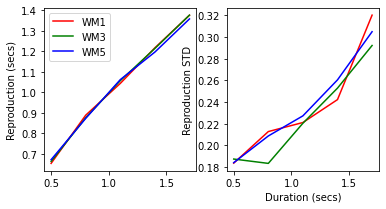

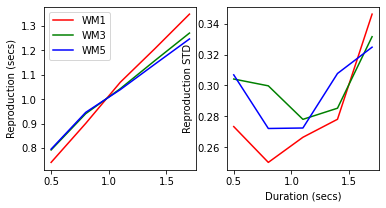

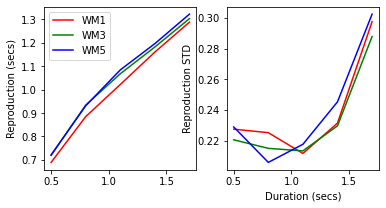

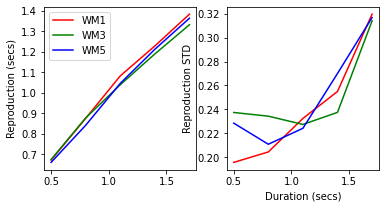

In [12]:
mdats = [getMeans(raw[i], withFigure = True) for i in range(0,4)]

## Model Framework

1. Sensory measure

$$ S = ln(D) + \epsilon $$

where $S \sim N(\mu_s, \sigma_s^2)$

Influence of cognitive load $M$:

$$ \mu_{wm} = \ln (D) - k_s \cdot M $$
$$ \sigma_{wm}^2 = \sigma_s^2 + l_s \cdot M $$

2. Memory mixing

$$\mu_{post} = w_p \mu_p + (1-w_p) u_{wm} $$

$$ w_p = \frac{1/\sigma_p^2}{1/\sigma_p^2 + 1/\sigma_{wm}^2}$$

3. Duration Reproduction

$$\mu_r = e^{\mu_{post} + k_r M + \sigma_{post}^2} $$

$$\sigma^2_r = |e^{\sigma_{post}^2-1}|\cdot e^{2(\mu_{post}+k_rM)+\sigma_{post}^2}$$

$$\sigma_{obs}^2 = \sigma_r^2 + \sigma_0^2/D$$

For partial pooling, we need to store parameters for individual participants. So it is convenient to use `NSub` if it is continuous. So first we check this.
In four experiments, it seems they are all tagged as 1 to 16. 

In [26]:
[raw[i].NSub.unique() for i in range(0,4)]

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])]

## Constrains on hierachical models. 

Given that the first experiment, working memory load is after duration task, so we contrain this with no memory influence on the production and reproduction phases. That is, $k_s, l_s, k_r$ all set to 0.

Experiment 2 manipulated the cognitive load in the production phase, so $k_r$ sets to 0. 

Experiment 3 manipulated the cognitive load in the reproduction phase, so $k_s, l_s$ set to 0. 

To implement such constrains, we use variable `constrain` with three elements to control. For example, Experiment 1 will be `constrain = [0,0,0]`.

In [36]:
# set global constrain and dat before define models. 
constrain = [0,0,0]
dat = raw[0]

In [52]:
 # %% partial pooling model
trace = 0
def findMAP(dat, constrain):
    #prepare data
    dat = dat.query("valid == 1 & repDur > 0.25 & repDur < 3.4")
    subid = dat.NSub - 1 # starting from index 0
    nsub = len(dat.NSub.unique())  # number of subject
    wm_idx = np.intc((dat.WMSize.values-1)/2)
    durs = dat.curDur.to_numpy()
    repDur = dat.repDur
    lnDur = np.log(durs)
    niter = 1000
    # define model
    with pm.Model() as WMmodel:
        # sensory measurement
        sig_s = pm.HalfNormal('sig_s',1., shape = nsub) # noise of the sensory measurement
        if constrain[0] == 1:
            k_s = pm.HalfNormal('k_s',1, shape = nsub) # working memory coeff. on ticks
        else:
            k_s = np.zeros(nsub)
        if constrain[1] == 1:
            l_s = pm.HalfNormal('l_s',1, shape = nsub) # working memory impacts on variance
        else:
            l_s = np.zeros(nsub)
        # sensory measurement with log encoding + ticks loss by memory task
        D_s = lnDur - k_s[subid] * wm_idx
        sig_sm = sig_s[subid] + l_s[subid] * wm_idx # variance influenced by memory tasks
        # prior (internal log encoding)
        mu_p = pm.Normal('mu_p', 0, sigma = 1,  shape = nsub) # in log space
        sig_p = pm.HalfNormal('sig_p', 1, shape = nsub) # in log-space

        if constrain[2] == 1:
            k_r = pm.HalfNormal('k_r', 1, shape = nsub) # working memory influence on reproduction   
        else:
            k_r = np.zeros(nsub)
        sig_n = pm.HalfNormal('sig_n', 1., shape = nsub) #pm.Bound( pm.HalfNormal, lower = 0.15)('sig_n', 5.) # constant decision /motor noise
        # integration
        w_p = sig_sm*sig_sm / (sig_p[subid]*sig_p[subid] + sig_sm*sig_sm)
        u_x = (1-w_p)*D_s + w_p * mu_p[subid]
        sig_x2 = sig_sm*sig_sm*sig_p[subid]*sig_p[subid]/(sig_sm*sig_sm + sig_p[subid]*sig_p[subid])

        # reproduction
        # reproduced duration
        u_r = np.exp(u_x + k_r[subid] * wm_idx + sig_x2/2) # reproduced duration with corrupted from memory task
        #reproduced sigmas
        sig_r = np.sqrt((np.exp(sig_x2)-1)*np.exp(2*(u_x + k_r[subid] * wm_idx) +sig_x2 )  + 
            sig_n[subid]*sig_n[subid] /durs)

        # Data likelihood 
        resp_like = pm.Normal('resp_like', mu = u_r, sigma = sig_r, observed = repDur)

        trace = pm.sample(draws=5000, tune = 1000, random_seed=123, progressbar=True)
       
         # inference
        start = pm.find_MAP() # method = "BFGS"
        #step = pm.Slice(vars = ["mu_p"]) 
       
        

    # use defined model to find MAP estimation
    pMap = pm.find_MAP(model=WMmodel)
    
    #step = pm.Metropolis() # Have a choice of samplers
    #trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)
    return  pMap, trace, WMmodel

## Results


First, find MAP estimations...

### Experiment 1

In [53]:
par1, trace1, wm_model = findMAP(raw[0], [0,0,0])

<ipython-input-52-0de00068a66f>:52: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=5000, tune = 1000, random_seed=123, progressbar=True)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sig_n, sig_p, mu_p, sig_s]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 324 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu_p'}>,
        <AxesSubplot:title={'center':'mu_p'}>],
       [<AxesSubplot:title={'center':'sig_s'}>,
        <AxesSubplot:title={'center':'sig_s'}>],
       [<AxesSubplot:title={'center':'sig_p'}>,
        <AxesSubplot:title={'center':'sig_p'}>],
       [<AxesSubplot:title={'center':'sig_n'}>,
        <AxesSubplot:title={'center':'sig_n'}>]], dtype=object)

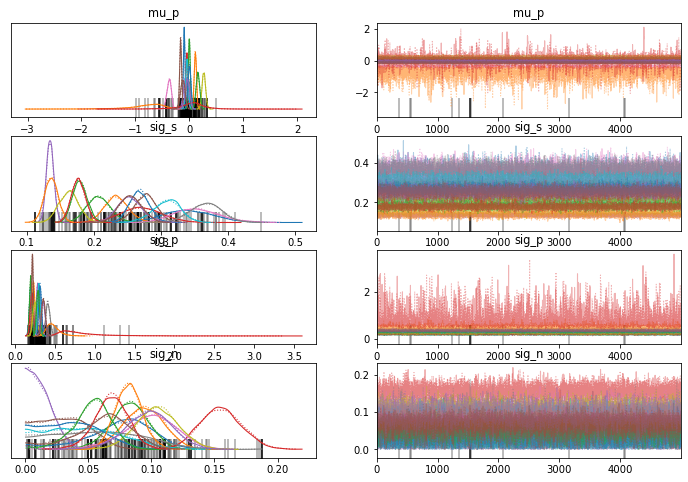

In [41]:
 az.plot_trace(trace1)

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/data/base.py:216: UserWarning: More chains (10000) than draws (16). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


<AxesSubplot:title={'center':'x'}>

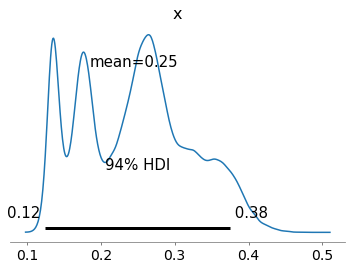

In [54]:
pm.plot_posterior(trace1['sig_s'])
#pm.plot_posterior(trace1['mu_p'])

## Graphing Model

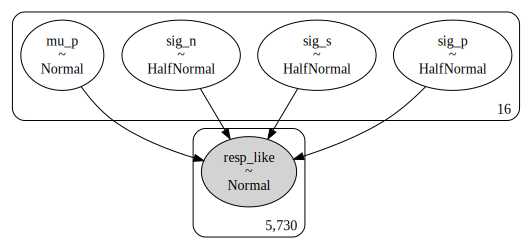

In [63]:
pm.model_to_graphviz(wm_model)

In [62]:
gv = pm.model_to_graphviz(wm_model)
gv.format = 'svg'
gv.render(filename='model_graph')

'model_graph.svg'

## plot posterior

/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/data/base.py:216: UserWarning: More chains (10000) than draws (16). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


<AxesSubplot:title={'center':'x'}>

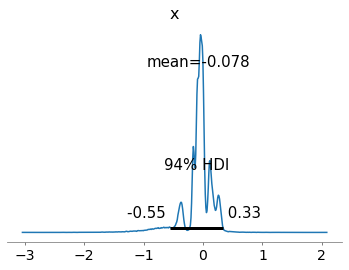

In [59]:
pm.plot_posterior(trace1['mu_p'])

In [60]:
print("mu_p", trace1['mu_p'].shape)

mu_p (10000, 16)


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

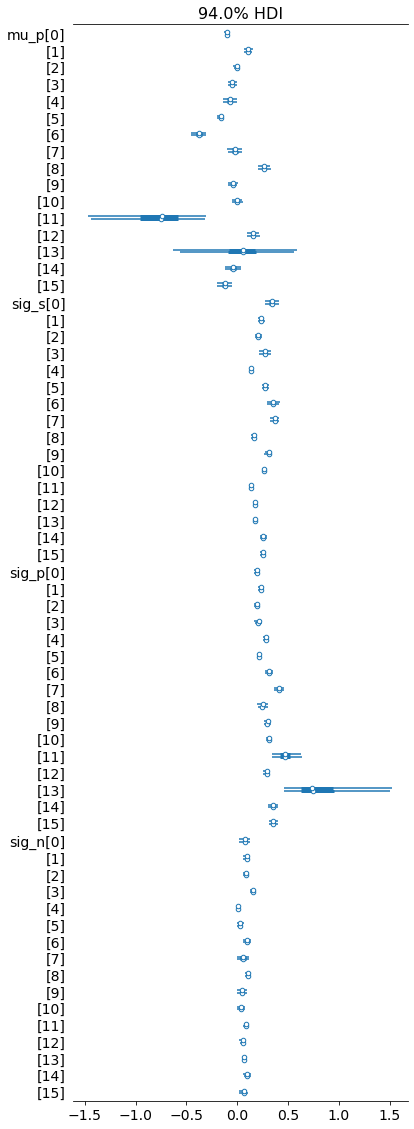

In [68]:
az.plot_forest(trace1)
#az.plot_forest(trace1[1000:], var_names = ['mu_p'])

Define a prediction function for all experiments. 

In [61]:
# see the goodness of fit
def mapPrediction(dat, par1, constrain):
    subid = dat.NSub - 1 # starting from index 0
    wm_idx = np.intc((dat.WMSize.values-1)/2)
    durs = dat.curDur.to_numpy()
    lnDur = np.log(durs)

    # sensory measure
    if constrain[0] == 1:
        u_wm = lnDur - par1['k_s'][subid] * wm_idx
    else:
        u_wm = lnDur
    if constrain[1] == 1:     
        s_wm = par1['sig_s'][subid]  + par1['l_s'][subid] * wm_idx
    else:
        s_wm = par1['sig_s'][subid]

    #weight of prior
    w_p = s_wm*s_wm / (par1['sig_p'][subid]*par1['sig_p'][subid] + \
        s_wm*s_wm)
    # integration
    u_post = (1-w_p)*u_wm + w_p * par1['mu_p'][subid]        
    s_post = s_wm*s_wm*par1['sig_p'][subid]*par1['sig_p'][subid]/(s_wm*s_wm + \
        par1['sig_p'][subid]*par1['sig_p'][subid])

    # reproduction
    if constrain[2] == 1:
        u_r = np.exp(u_post + par1['k_r'][subid] * wm_idx + s_post/2) # reproduced duration with corrupted from memory task
    else:
        u_r = np.exp(u_post + s_post/2) # reproduced duration with corrupted from memory task

    sig_r = np.sqrt((np.exp(s_post)-1)*np.exp(2*(u_post) +s_post ) + par1['sig_n'][subid]*par1['sig_n'][subid] /durs )

    dat.loc[:,'predDur'] = u_r
    dat.loc[:,'predSig'] = sig_r
    dat.loc[:,'w_p'] = w_p
    dat.loc[:,'mu_post']  = u_post
    dat.loc[:,'mu_p'] = par1['mu_p'][subid]
    dat.loc[:,'mu_wm'] = u_wm
    mdat = dat.groupby(['NSub','curDur','WMSize']).agg(
        {'repDur':['mean','std'],'predDur':'mean', 'predSig' : 'mean', 'w_p':'mean', 
        'mu_post':'mean', 'mu_p':'mean', 'mu_wm':'mean'}
        ).droplevel(axis=1, level=0).reset_index()
    # flaten column names, making names ambigous, rename them
    mdat.columns = ['Nsub', 'curDur','WMSize','mRep', 'sdRep', 'mPred','sdPred','w_p', 'mu_post','mu_p','mu_wm']
    return mdat

Now we do average for individual participants behavioral results and predictions. 

In [15]:
# get predictions
mdat1 = mapPrediction(raw[0], par1, [0,0,0])
mdat1.head()

,Nsub,curDur,WMSize,mRep,sdRep,mPred,sdPred,w_p,mu_post,mu_p,mu_wm
0,1,0.5,1,0.696649,0.208368,0.792242,0.176232,0.748317,-0.246539,-0.096331,-0.693147
1,1,0.5,3,0.825337,0.203701,0.792242,0.176232,0.748317,-0.246539,-0.096331,-0.693147
2,1,0.5,5,0.779297,0.206872,0.792242,0.176232,0.748317,-0.246539,-0.096331,-0.693147
3,1,0.8,1,0.908631,0.132347,0.891726,0.174822,0.748317,-0.128247,-0.096331,-0.223144
4,1,0.8,3,0.899939,0.243163,0.891726,0.174822,0.748317,-0.128247,-0.096331,-0.223144


In [25]:
# new test data to test the model
curDur = np.arange(0.4,1.8,0.01).tolist()
test_dat = pd.DataFrame()
for k in range(1,17):
    for x in range(1,4):
        tempdat = pd.DataFrame({'curDur': curDur, 
                             'WMSize': [2*x-1]*len(curDur), 
                             'valid': [1]*len(curDur), 
                             'repDur': [1]*len(curDur),
                             'NSub': [k]*len(curDur)} )
        test_dat = test_dat.append(pd.DataFrame(data = tempdat))

test_dat

,curDur,WMSize,valid,repDur,NSub
0,0.40,1,1,1,1
1,0.41,1,1,1,1
2,0.42,1,1,1,1
3,0.43,1,1,1,1
4,0.44,1,1,1,1
...,...,...,...,...,...
135,1.75,5,1,1,16
136,1.76,5,1,1,16
137,1.77,5,1,1,16
138,1.78,5,1,1,16


In [26]:
test_rlt1 = mapPrediction(test_dat, par1, [0,0,0])
test_rlt1.drop(columns = ['mRep', 'sdRep'])
test_rlt1.head()

,Nsub,curDur,WMSize,mRep,sdRep,mPred,sdPred,w_p,mu_post,mu_p,mu_wm
0,1,0.40,1,1,NaN,0.748975,0.180647,0.748317,-0.302701,-0.096331,-0.916291
1,1,0.40,3,1,NaN,0.748975,0.180647,0.748317,-0.302701,-0.096331,-0.916291
2,1,0.40,5,1,NaN,0.748975,0.180647,0.748317,-0.302701,-0.096331,-0.916291
3,1,0.41,1,1,NaN,0.753644,0.180029,0.748317,-0.296486,-0.096331,-0.891598
4,1,0.41,3,1,NaN,0.753644,0.180029,0.748317,-0.296486,-0.096331,-0.891598


Now we obtain grand means for plotting...

In [27]:
# define a plotting function
#Visualize 
def plotPred(mmdat):
    markers = 'dov'
    colors = 'bcr'
    fig, axs = plt.subplots(1, 3, figsize = (12,4))
    for m in range(3):
        cur = mmdat[mmdat.WMSize == 1 + 2*m]
        axs[0].plot(cur.curDur, cur.mRep,markers[m]+colors[m])
        axs[0].plot(cur.curDur, cur.mPred,colors[m])
        axs[1].plot(cur.curDur, cur.sdRep,markers[m]+colors[m])
        axs[1].plot(cur.curDur, cur.sdPred,colors[m])
        axs[2].plot(cur.curDur, cur.sdRep/cur.mRep,markers[m]+colors[m])
        axs[2].plot(cur.curDur, cur.sdPred/cur.mPred,colors[m])
    axs[0].legend(['low',"medium","high"])
    axs[0].set_ylabel('Reproduction (secs)')
    axs[1].set_ylabel('Reproduction SD')
    axs[2].set_ylabel('CV')
    axs[2].set_xlabel('Sample intervals (secs)')
    plt.show(fig)
    

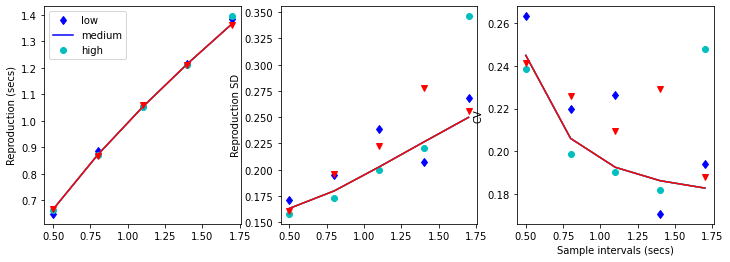

In [29]:
#grand average
mmdat1 = mdat1.groupby(['curDur','WMSize']).agg(
    {'mRep':'mean', 'sdRep':'mean','mPred':'mean','sdPred':'mean'}).reset_index()
plotPred(mmdat1)

Do the same for Exps. 2, 3, and 4. 

### Experiment 2

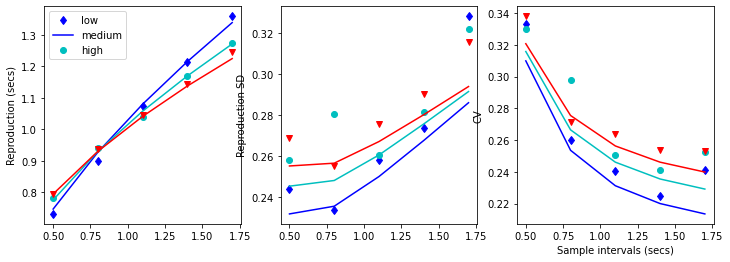

In [30]:
par2, trace2 = findMAP(raw[1], [1,1,0])
mdat2 = mapPrediction(raw[1],par2, [1,1,0])
mmdat2 = mdat2.groupby(['curDur','WMSize']).agg(
    {'mRep':'mean', 'sdRep':'mean','mPred':'mean','sdPred':'mean'}).reset_index()
plotPred(mmdat2)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu_p'}>,
        <AxesSubplot:title={'center':'mu_p'}>],
       [<AxesSubplot:title={'center':'sig_s'}>,
        <AxesSubplot:title={'center':'sig_s'}>],
       [<AxesSubplot:title={'center':'k_s'}>,
        <AxesSubplot:title={'center':'k_s'}>],
       [<AxesSubplot:title={'center':'l_s'}>,
        <AxesSubplot:title={'center':'l_s'}>],
       [<AxesSubplot:title={'center':'sig_p'}>,
        <AxesSubplot:title={'center':'sig_p'}>],
       [<AxesSubplot:title={'center':'sig_n'}>,
        <AxesSubplot:title={'center':'sig_n'}>]], dtype=object)

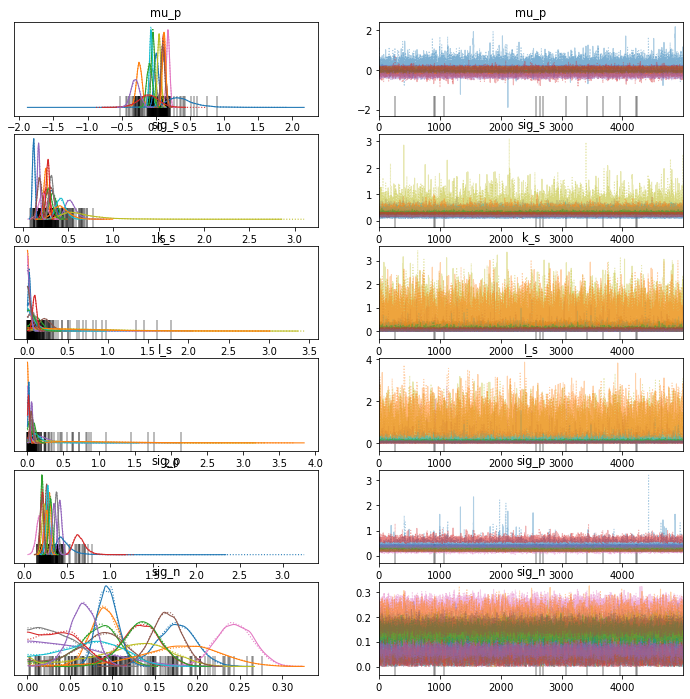

In [107]:
 az.plot_trace(trace2)

In [31]:
test_rlt2 = mapPrediction(test_dat, par2, [1,1,0])
test_rlt2.drop(columns = ['mRep', 'sdRep'])
test_rlt2.head()

,Nsub,curDur,WMSize,mRep,sdRep,mPred,sdPred,w_p,mu_post,mu_p,mu_wm
0,1,0.40,1,1,NaN,0.714786,0.317519,0.610775,-0.357041,-0.000652,-0.916291
1,1,0.40,3,1,NaN,0.708557,0.316940,0.611258,-0.365811,-0.000652,-0.939986
2,1,0.40,5,1,NaN,0.702397,0.316370,0.611739,-0.374559,-0.000652,-0.963681
3,1,0.41,1,1,NaN,0.721689,0.315170,0.610775,-0.347430,-0.000652,-0.891598
4,1,0.41,3,1,NaN,0.715391,0.314574,0.611258,-0.356212,-0.000652,-0.915293


### Experiment 3

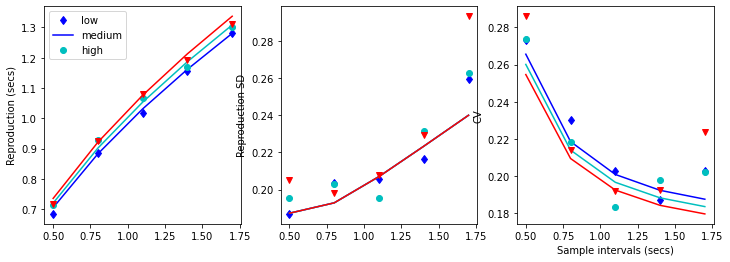

In [32]:
par3, trace3 = findMAP(raw[2], [0,0,1])
mdat3 = mapPrediction(raw[2],par3, [0,0,1])
mmdat3 = mdat3.groupby(['curDur','WMSize']).agg(
    {'mRep':'mean', 'sdRep':'mean','mPred':'mean','sdPred':'mean'}).reset_index()
plotPred(mmdat3)

In [33]:
test_rlt3 = mapPrediction(test_dat, par3, [0,0,1])
test_rlt3.drop(columns = ['mRep', 'sdRep'])
test_rlt3.head()

,Nsub,curDur,WMSize,mRep,sdRep,mPred,sdPred,w_p,mu_post,mu_p,mu_wm
0,1,0.40,1,1,NaN,0.695553,0.269848,0.624615,-0.376319,-0.051804,-0.916291
1,1,0.40,3,1,NaN,0.697890,0.269848,0.624615,-0.376319,-0.051804,-0.916291
2,1,0.40,5,1,NaN,0.700234,0.269848,0.624615,-0.376319,-0.051804,-0.916291
3,1,0.41,1,1,NaN,0.702030,0.267587,0.624615,-0.367050,-0.051804,-0.891598
4,1,0.41,3,1,NaN,0.704389,0.267587,0.624615,-0.367050,-0.051804,-0.891598


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu_p'}>,
        <AxesSubplot:title={'center':'mu_p'}>],
       [<AxesSubplot:title={'center':'sig_s'}>,
        <AxesSubplot:title={'center':'sig_s'}>],
       [<AxesSubplot:title={'center':'sig_p'}>,
        <AxesSubplot:title={'center':'sig_p'}>],
       [<AxesSubplot:title={'center':'k_r'}>,
        <AxesSubplot:title={'center':'k_r'}>],
       [<AxesSubplot:title={'center':'sig_n'}>,
        <AxesSubplot:title={'center':'sig_n'}>]], dtype=object)

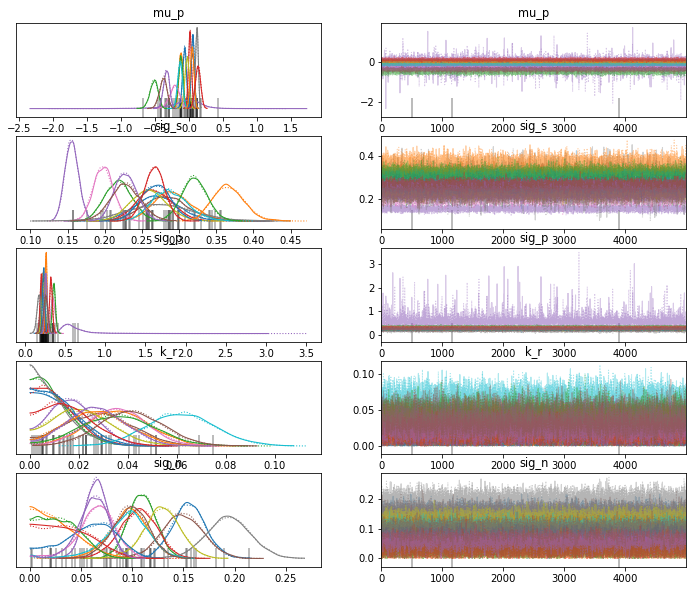

In [111]:
 az.plot_trace(trace3)

### Experiment 4


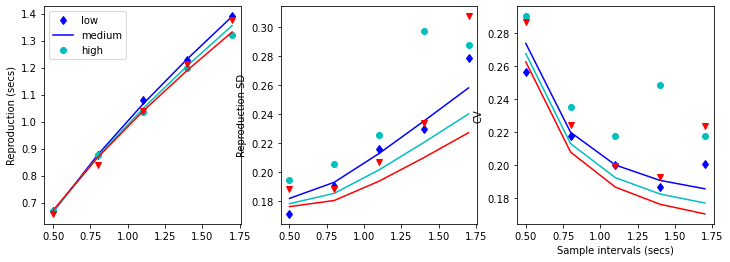

In [34]:
par4, trace4 = findMAP(raw[3], [1,1,1])
mdat4 = mapPrediction(raw[3],par4, [1,1,1])
mmdat4 = mdat4.groupby(['curDur','WMSize']).agg(
    {'mRep':'mean', 'sdRep':'mean','mPred':'mean','sdPred':'mean'}).reset_index()
plotPred(mmdat4)

In [35]:
test_rlt4 = mapPrediction(test_dat, par4, [1,1,1])
test_rlt4.drop(columns = ['mRep', 'sdRep'])
test_rlt4.head()

,Nsub,curDur,WMSize,mRep,sdRep,mPred,sdPred,w_p,mu_post,mu_p,mu_wm
0,1,0.40,1,1,NaN,0.546413,0.204517,0.400868,-0.622012,-0.182186,-0.916291
1,1,0.40,3,1,NaN,0.538668,0.203060,0.401038,-0.650748,-0.182186,-0.964476
2,1,0.40,5,1,NaN,0.531040,0.201674,0.401207,-0.679469,-0.182186,-1.012661
3,1,0.41,1,1,NaN,0.554557,0.203446,0.400868,-0.607218,-0.182186,-0.891598
4,1,0.41,3,1,NaN,0.546694,0.201937,0.401038,-0.635958,-0.182186,-0.939783


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu_p'}>,
        <AxesSubplot:title={'center':'mu_p'}>],
       [<AxesSubplot:title={'center':'sig_s'}>,
        <AxesSubplot:title={'center':'sig_s'}>],
       [<AxesSubplot:title={'center':'k_s'}>,
        <AxesSubplot:title={'center':'k_s'}>],
       [<AxesSubplot:title={'center':'l_s'}>,
        <AxesSubplot:title={'center':'l_s'}>],
       [<AxesSubplot:title={'center':'sig_p'}>,
        <AxesSubplot:title={'center':'sig_p'}>],
       [<AxesSubplot:title={'center':'k_r'}>,
        <AxesSubplot:title={'center':'k_r'}>],
       [<AxesSubplot:title={'center':'sig_n'}>,
        <AxesSubplot:title={'center':'sig_n'}>]], dtype=object)

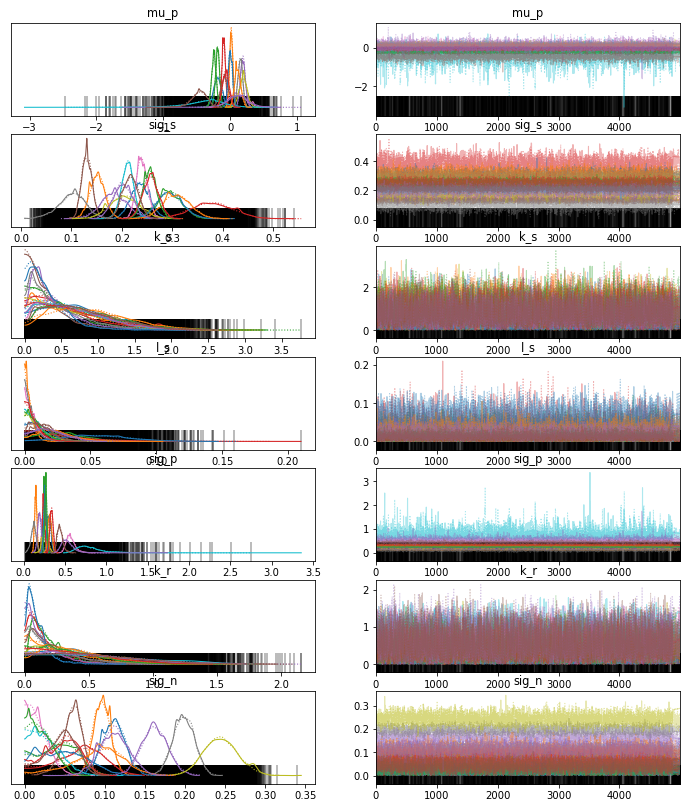

In [114]:
az.plot_trace(trace4)

## Save parameters and predictions

Now we save parameters and predictions to csv files for further R statistical analyses. 


In [36]:
pd.DataFrame(par1).to_csv(cwd+'/../data/'+'par_exp1.csv')
pd.DataFrame(par2).to_csv(cwd+'/../data/'+'par_exp2.csv')
pd.DataFrame(par3).to_csv(cwd+'/../data/'+'par_exp3.csv')
pd.DataFrame(par4).to_csv(cwd+'/../data/'+'par_exp4.csv')
mdat1.to_csv(cwd+'/../data/'+'mpred1.csv')
mdat2.to_csv(cwd+'/../data/'+'mpred2.csv')
mdat3.to_csv(cwd+'/../data/'+'mpred3.csv')
mdat4.to_csv(cwd+'/../data/'+'mpred4.csv')
test_rlt1.to_csv(cwd+'/../data/'+'testrlt1.csv')
test_rlt2.to_csv(cwd+'/../data/'+'testrlt2.csv')
test_rlt3.to_csv(cwd+'/../data/'+'testrlt3.csv')
test_rlt4.to_csv(cwd+'/../data/'+'testrlt4.csv')